In [1]:
import torch
import torch.nn.functional as F
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from itertools import chain
from itertools import groupby
from functools import reduce
from typing import Collection, List
from pathlib import Path
import music21 as m21
musescore_path = '/usr/bin/mscore'
m21.environment.set('musicxmlPath', musescore_path)
m21.environment.set('musescoreDirectPNGPath', musescore_path)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device}.")

Using cuda.


In [2]:
if device == "cuda":
    print(f"Device: {torch.cuda.get_device_name()}.")

Device: NVIDIA GeForce RTX 4090.


To start with lets bring in our import / encode / decode functions from last time.

In [3]:
BEATS_PER_BAR = 4 # beats per bar
DIVISIONS_PER_QUARTER = 4 # i.e. 4 beats per bar and 4 divisions per beat gives 16 divisions per bar
MIDI_NOTE_COUNT = 128
MAX_NOTE_DUR = (8*BEATS_PER_BAR*DIVISIONS_PER_QUARTER)
SEPARATOR_IDX = -1 # separator value for numpy encoding
PIANO_RANGE = (21, 108)
SOS = '<|sos|>' # Start of sequence
EOS = '<|eos|>' # End of sequence
SEP = '<|sep|>' # End of timestep (required for polyphony). Note index -1
PAD = '<|pad|>' # Padding to ensure blocks are the same size
 # SEP token must be last, i.e. one place before note tokens, so that adding the note offset still works when encoding
SPECIAL_TOKENS = [SOS, EOS, PAD, SEP]
MIDI_NOTE_COUNT = 128
NOTE_TOKENS = [f'n{i}' for i in range(MIDI_NOTE_COUNT)]
DURATION_SIZE = 8 * BEATS_PER_BAR * DIVISIONS_PER_QUARTER + 1 # 8 bars of sixteenth (semiquaver) notes + 1 for 0 length
DURATION_TOKENS = [f'd{i}' for i in range(DURATION_SIZE)]
NOTE_START, NOTE_END = NOTE_TOKENS[0], NOTE_TOKENS[-1]
DURATION_START, DURATION_END = DURATION_TOKENS[0], DURATION_TOKENS[-1]
ALL_TOKENS = SPECIAL_TOKENS + NOTE_TOKENS + DURATION_TOKENS
ALL_TOKENS[0:8]
TIMESIG = f'{BEATS_PER_BAR}/4'
block_size = 3 # If you change this, you need to generate data for the new block size

class MusicVocab():
    def __init__(self):
        itos = SPECIAL_TOKENS + NOTE_TOKENS + DURATION_TOKENS
        # Ensure that the vocab is a multiple of 8 for fp16 training
        if len(itos)%8 != 0:
            itos = itos + [f'dummy{i}' for i in range(len(itos)%8)]
        self.itos = itos
        self.stoi = {v:k for k,v in enumerate(self.itos)}

    def to_indices(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their indices."
        return [self.stoi[w] for w in t]

    def to_tokens(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of indices to their tokens."
        items = [self.itos[i] for i in nums]
        return sep.join(items) if sep is not None else items

    @property
    def sos_idx(self): return self.stoi[SOS]
    @property
    def eos_idx(self): return self.stoi[EOS]
    @property
    def sep_idx(self): return self.stoi[SEP]
    @property
    def pad_idx(self): return self.stoi[PAD]
    @property
    def note_position_enc_range(self): return (self.stoi[SEP], self.stoi[DURATION_END]+1)
    @property
    def note_range(self): return self.stoi[NOTE_START], self.stoi[NOTE_END]+1
    @property
    def duration_range(self): return self.stoi[DURATION_START], self.stoi[DURATION_END]+1
    @property
    def size(self): return len(self.itos)

def stream_to_sparse_enc(stream_score, note_size=MIDI_NOTE_COUNT, sample_freq=DIVISIONS_PER_QUARTER, max_note_dur=MAX_NOTE_DUR):    
    # Time is measured in quarter notes since the start of the piece
    # Original states that we are assuming 4/4 time but I don't see why that would be the case. BPB isn't used here.

    # (MusicAutobot author:) TODO: need to order by instruments most played and filter out percussion or include the channel
    highest_time = max(
        stream_score.flatten().getElementsByClass('Note').stream().highestTime,
        stream_score.flatten().getElementsByClass('Chord').stream().highestTime)
    
    # Calculate the maximum number of time steps
    max_timestep = round(highest_time * sample_freq) + 1
    sparse_score = np.zeros((max_timestep, len(stream_score.parts), note_size), dtype=np.int32)

    # Convert a note to a tuple of (pitch,offset,duration)
    def note_data(pitch, note):
        return (pitch.midi, int(round(note.offset*sample_freq)), int(round(note.duration.quarterLength*sample_freq)))

    for idx, part in enumerate(stream_score.parts):
        
        notes = chain.from_iterable(
            [note_data(elem.pitch, elem)] if isinstance(elem, m21.note.Note)
            else [note_data(p, elem) for p in elem.pitches] if isinstance(elem, m21.chord.Chord) 
            else []
            for elem in part.flatten()
        )

        # sort flattened note list by timestep (1), duration (2) so that hits are not overwritten and longer notes have priority
        notes_sorted = sorted(notes, key=lambda x: (x[1], x[2])) 

        for note in notes_sorted:
            if note is not None:
                pitch, timestep, duration = note
                clamped_duration = max_note_dur if max_note_dur is not None and duration > max_note_dur else duration
                sparse_score[timestep, idx, pitch] = clamped_duration
    
    return sparse_score

# Pass in the 'one-hot' encoded numpy score
def sparse_to_position_enc(sparse_score, skip_last_rest=True):

    def encode_timestep(acc, timestep):
        encoded_timesteps, wait_count = acc
        encoded_timestep = timestep_to_position_enc(timestep) # pass in all notes for both instruments, merged list returned
        if len(encoded_timestep) == 0: # i.e. all zeroes at time step
            wait_count += 1
        else:
            if wait_count > 0:
                encoded_timesteps.append([SEPARATOR_IDX, wait_count])
            encoded_timesteps.extend(encoded_timestep)
            wait_count = 1
        return encoded_timesteps, wait_count
    
    encoded_timesteps, final_wait_count = reduce(encode_timestep, sparse_score, ([], 0))

    if final_wait_count > 0 and not skip_last_rest:
        encoded_timesteps.append([SEPARATOR_IDX, final_wait_count]) # add trailing rests

    return np.array(encoded_timesteps).reshape(-1, 2) # reshaping. Just in case result is empty
    
def timestep_to_position_enc(timestep, note_range=PIANO_RANGE):

    note_min, note_max = note_range

    def encode_note_data(note_data, active_note_idx):
        instrument, pitch = active_note_idx
        duration = timestep[instrument, pitch]
        if pitch >= note_min and pitch < note_max:
            note_data.append([pitch, duration, instrument])
        return note_data
    
    active_note_idxs = zip(*timestep.nonzero())
    encoded_notes = reduce(encode_note_data, active_note_idxs, [])
    sorted_notes = sorted(encoded_notes, key=lambda x: x[0], reverse=True) # sort by note (highest to lowest)

    # Dropping instrument information for simplicity.
    # MusicAutobot allows different encoding schemes which include instrument number and split pitch into class / octave.
    return [n[:2] for n in sorted_notes]

def position_to_idx_enc(note_position_score, vocab):
    note_idx_score = note_position_score.copy()
    note_min_idx, _ = vocab.note_range
    dur_min_idx, _ = vocab.duration_range
    
    # Replace note and duration tokens with their index in vocab. 
    # Tokens are the same order as notes and note_min_idx offset is constant so we can apply in one go.
    # Using broadcasting to add the 1D [note_min_idx, dur_min_idx] to the 2D note_idx_score.
    note_idx_score += np.array([note_min_idx, dur_min_idx])
    
    prefix =  np.array([vocab.sos_idx])
    padding = np.full((block_size - 1), vocab.pad_idx)
    suffix = np.array([vocab.eos_idx])

    return np.concatenate([padding, prefix, note_idx_score.reshape(-1), suffix])

def import_midi_file(file_path):
    midifile = m21.midi.MidiFile()
    if isinstance(file_path, bytes):
        midifile.readstr(file_path)
    else:
        midifile.open(file_path)
        midifile.read()
        midifile.close()
    return midifile

def midifile_to_stream(midifile): 
    return m21.midi.translate.midiFileToStream(midifile)

def midifile_to_idx_score(file_path, vocab):
    midifile = import_midi_file(file_path)
    stream = midifile_to_stream(midifile)
    sparse_score = stream_to_sparse_enc(stream)
    note_pos_score = sparse_to_position_enc(sparse_score)
    return position_to_idx_enc(note_pos_score, vocab)

# Combining notes with different durations into a single chord may overwrite conflicting durations.
def group_notes_by_duration(notes):
    get_note_quarter_length = lambda note: note.duration.quarterLength
    sorted_notes = sorted(notes, key=get_note_quarter_length)
    return [list(g) for k,g in groupby(sorted_notes, get_note_quarter_length)]

def sparse_instrument_to_stream_part(sparse_instrument_score, step_duration):
    part = m21.stream.Part()
    part.append(m21.instrument.Piano())
    
    for t_idx, pitch_values in enumerate(sparse_instrument_score):

        def decode_sparse_note(notes, pitch_index):
            note = m21.note.Note(pitch_index)
            quarters = sparse_instrument_score[t_idx, pitch_index]
            note.duration = m21.duration.Duration(float(quarters) * step_duration.quarterLength)
            notes.append(note)
            return notes
        
        pitch_idxs = np.nonzero(pitch_values)[0]

        if len(pitch_idxs) != 0: 
            notes = reduce(decode_sparse_note, pitch_idxs, [])
            for note_group in group_notes_by_duration(notes):
                note_position = t_idx*step_duration.quarterLength
                if len(note_group) == 1:
                    part.insert(note_position, note_group[0])
                else:
                    chord = m21.chord.Chord(note_group)
                    part.insert(note_position, chord)

    return part

def sparse_to_stream_enc(sparse_score, bpm=120):
    step_duration = m21.duration.Duration(1. / DIVISIONS_PER_QUARTER)
    stream = m21.stream.Score()
    stream.append(m21.meter.TimeSignature(TIMESIG))
    stream.append(m21.tempo.MetronomeMark(number=bpm))

    # Not required here but left as example of options available
    stream.append(m21.key.KeySignature(0))
    
    for inst in range(sparse_score.shape[1]):
        part = sparse_instrument_to_stream_part(sparse_score[:,inst,:], step_duration)
        stream.append(part)
    
    # Again, not required yet but left as example
    stream = stream.transpose(0)
    
    return stream

def position_to_sparse_enc(note_position_score):

    # Add all the separator durations as they denote the elapsed time
    score_length = sum(timestep[1] for timestep in note_position_score if timestep[0] == SEPARATOR_IDX) + 1
    
    # Single instrument as we discarded the instrument information when encoding
    # We will adapt to handle multiple instruments later
    instrument = 0

    def decode_note_position_step(acc, note_pos_step):
        timestep, sparse_score = acc
        note, duration = note_pos_step.tolist()
        if note < SEPARATOR_IDX:  # Skip special token
            return acc
        elif note == SEPARATOR_IDX:  # Time elapsed
            return (timestep + duration, sparse_score)
        else:
            sparse_score[timestep, instrument, note] = duration
            return (timestep, sparse_score)

     # (timesteps, instruments, pitches)
    initial_sparse_score = np.zeros((score_length, 1, MIDI_NOTE_COUNT))
    _, final_sparse_score = reduce(decode_note_position_step, note_position_score, (0, initial_sparse_score))

    return final_sparse_score

# No validation of note position encoding included to keep it simple for now
def idx_to_position_enc(idx_score, vocab):
    
    # Filter out special tokens
    notes_durs_start, notes_durs_end = vocab.note_position_enc_range # range of non-special token values
    notes_durations_idx_score = idx_score[np.where((idx_score >= notes_durs_start) & (idx_score < notes_durs_end))]

    # Reshape into pairs of (note, duration). If odd number of tokens, discard the last token.
    if notes_durations_idx_score.shape[0] % 2 != 0:
        notes_durations_idx_score = notes_durations_idx_score[:-1]

    position_score = notes_durations_idx_score.copy().reshape(-1, 2)
    
    # Shift token index values to note and duration values
    if position_score.shape[0] == 0: 
        return position_score
    else:
        note_min_idx, _ = vocab.note_range
        dur_min_idx, _ = vocab.duration_range
        position_score -= np.array([note_min_idx, dur_min_idx])
        return position_score

def idx_to_stream_enc(idx_score, vocab):
    position_score = idx_to_position_enc(idx_score, vocab)
    sparse_score = position_to_sparse_enc(position_score)
    return sparse_to_stream_enc(sparse_score)

vocab = MusicVocab()

And a quick test...

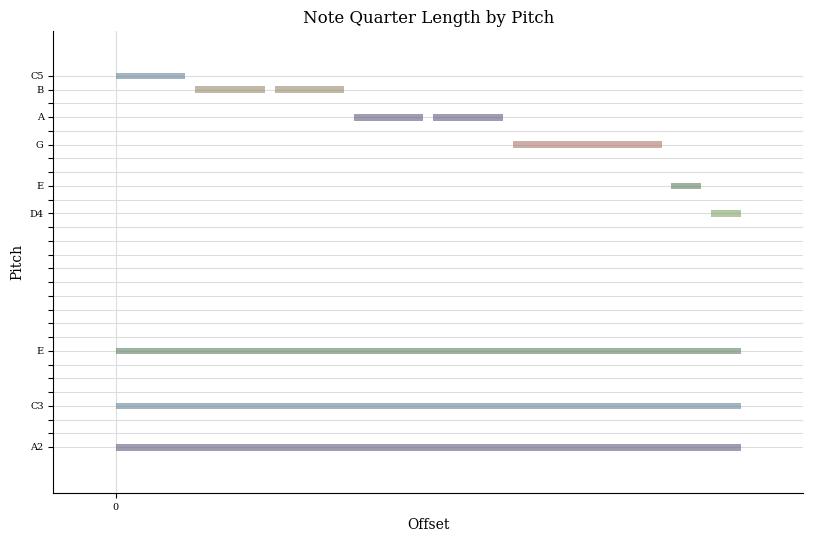

In [4]:
single_bar_path = Path('data/midi/single_bar_example.mid')
single_bar_idx_score = midifile_to_idx_score(single_bar_path, vocab)
single_bar_stream = idx_to_stream_enc(single_bar_idx_score, vocab)
single_bar_stream.plot()

# Loading Data

We have two options when loading data from multiple sources into training batches.

1. Concatenate all the sources into one long sequence, with a separator token between (`<|eos|>` in our case). We can then just window through the sequence to pick batches.

2. Treat each source as a single batch, and pad shorter sequences to the length of the longest so they are all consistent.

`1.` is simpler to implement, although it does make it harder for the model to distinguish between sequence boundaries as it has to learn that nothing before an `<|eos|>` token is relevant to anything after it.

`2.` on the other hand has explicit sequence boundaries, but wastes training resources processing `<|pad|>` tokens.

For this reason, lets go with `1.`

The process will be

- Load each file
- Tokenise it
- Split them into x samples and y labels
- Concatenate all the xs into one long collection of samples and the ys into one collection of labels

> If we assign labels *before* we concatenate then we avoid having anything follow `<|eos|>` in the training data.

In [5]:
vg_path = Path('data/midi/vg')
vg_file_names = [f for f in os.listdir(vg_path) if os.path.isfile(os.path.join(vg_path, f))]
vg_file_names[0:3]

['Ace Attorney_3DS_Phoenix Wright Ace Attorney Spirit of Justice_Cheerful People.mid',
 'Animal Crossing_3DS_Animal Crossing New Leaf_100 AM.mid',
 "Banjo-Kazooie_GBA_Banjo-Kazooie Grunty's Revenge_Breegull Beach.mid"]

In [6]:
len(vg_file_names)

40

### Bigram revisited

To start with, let's do a simple bigram encoding as we did in the previous workbook, but this time on the bigger dataset.

In [7]:
def bigram_encode(file_names, vocab):
    xs, ys = [], []
    for file_name in file_names:
        file_path = Path(vg_path, file_name)
        idx_score = midifile_to_idx_score(file_path, vocab)
        xs.append(idx_score[:-1])
        ys.append(idx_score[1:])
    return np.concatenate(xs), np.concatenate(ys)

vg_bigram_samples = Path(f'data/numpy/vg/bigram_samples.npy')
vg_bigram_labels = Path(f'data/numpy/vg/bigram_labels.npy')

if vg_bigram_samples.exists() and vg_bigram_labels.exists():
    xs, ys = np.load(vg_bigram_samples, allow_pickle=True), np.load(vg_bigram_labels, allow_pickle=True)
else:
    xs, ys = bigram_encode(vg_file_names, vocab)
    np.save(vg_bigram_samples, xs)
    np.save(vg_bigram_labels, ys)

xs.shape, ys.shape

((137166,), (137166,))

In [8]:
for _, (x, y) in enumerate(zip(xs[:5], ys[:5])):
    print(f'x: {vocab.to_tokens([x])}, y:{vocab.to_tokens([y])}')

x: <|pad|>, y:<|pad|>
x: <|pad|>, y:<|sos|>
x: <|sos|>, y:n31
x: n31, y:d3
x: d3, y:<|sep|>


# MLP

We are going to try to roughly follow part 2 of Karpathy's Makemore and use a simple MLP to improve our bigram results (along with a bigger data set!)

Spoiler alert, it still won't be very good, but we might see a glimmer of improvement....

### Expanding the context

In our bigram encoding, we asked 'if the input sequence is `[a]`, what is the output token?'.

Now we want to expand the input context - i.e. we are asking 'if the input is `[a, b, c]`, what is the output token?'

We still want to only move the window forward by one token for each example to get the most we can out of our dataset.

Let's also take the opportunity to load an even bigger data set.

We can split this into train, dev and test sets to allow us to assess performance more accurately.

In [9]:
vg_large_path = Path('data/midi/vg_large')
vg_large_file_names = [f for f in os.listdir(vg_large_path) if os.path.isfile(os.path.join(vg_large_path, f))]
vg_large_file_names[0:3]

['Ace Attorney_Nintendo 3DS_Phoenix Wright Ace Attorney Spirit of Justice_Cheerful People.mid',
 'Ace Attorney_Nintendo DS_Ace Attorney Investigations Miles Edgeworth_Kay Faraday The Great Truth Burglar.mid',
 'Ace Attorney_Nintendo DS_Ace Attorney Investigations Miles Edgeworth_Pursuit Lying Coldly.mid']

In [10]:
len(vg_large_file_names)

3839

In [11]:
def block_encode(file_names, vocab, block_size):
    xs, ys = [], []
    for file_name in file_names:
        file_path = Path(vg_large_path, file_name)
        idx_score = midifile_to_idx_score(file_path, vocab)
        for i in range(0, len(idx_score) - block_size, 1):
            xs.append(idx_score[i:i+block_size])
            ys.append(idx_score[i+block_size])
    return np.stack(xs), ys # stack xs to create 2D tensor

random.seed(42)
random.shuffle(vg_large_file_names)
n1 = int(0.8 * len(vg_large_file_names))
n2 = int(0.9 * len(vg_large_file_names))
train_filenames = vg_large_file_names[:n1]
valid_filenames = vg_large_file_names[n1:n2]
test_filenames = vg_large_file_names[n2:]

vg_large_block_samples_train = Path(f'data/numpy/vg_large/block_{block_size}_samples_train.npy')
vg_large_block_labels_train = Path(f'data/numpy/vg_large/block_{block_size}_labels_train.npy')
vg_large_block_samples_valid = Path(f'data/numpy/vg_large/block_{block_size}_samples_valid.npy')
vg_large_block_labels_valid = Path(f'data/numpy/vg_large/block_{block_size}_labels_valid.npy')
vg_large_block_samples_test = Path(f'data/numpy/vg_large/block_{block_size}_samples_test.npy')
vg_large_block_labels_test = Path(f'data/numpy/vg_large/block_{block_size}_labels_test.npy')

def load_or_create(file_names, vocab, block_samples, block_labels):
    if block_samples.exists() and block_labels.exists():
        xs, ys = np.load(block_samples, allow_pickle=True), np.load(block_labels, allow_pickle=True)
    else:
        xs, ys = block_encode(file_names, vocab, block_size)
        np.save(block_samples, xs)
        np.save(block_labels, ys)
    return torch.tensor(xs, device=device), torch.tensor(ys, device=device)

Xtrain, Ytrain = load_or_create(train_filenames, vocab, vg_large_block_samples_train, vg_large_block_labels_train)
Xvalid, Yvalid = load_or_create(valid_filenames, vocab, vg_large_block_samples_valid, vg_large_block_labels_valid)
Xtest, Ytest = load_or_create(test_filenames, vocab, vg_large_block_samples_test, vg_large_block_labels_test)

In [12]:
for _, (x, y) in enumerate(zip(Xtrain[:5], Ytrain[:5])):
    print(f'x: {vocab.to_tokens(x)}, y:{vocab.to_tokens([y])}')

x: <|pad|> <|pad|> <|sos|>, y:n71
x: <|pad|> <|sos|> n71, y:d4
x: <|sos|> n71 d4, y:n68
x: n71 d4 n68, y:d4
x: d4 n68 d4, y:n63


In [13]:
Xtrain.shape, Xtrain.dtype, Ytrain.shape, Ytrain.dtype

(torch.Size([9281963, 3]), torch.int64, torch.Size([9281963]), torch.int64)

In [14]:
Xvalid.shape, Xvalid.dtype, Yvalid.shape, Yvalid.dtype

(torch.Size([1230454, 3]), torch.int64, torch.Size([1230454]), torch.int64)

In [15]:
Xtest.shape, Xtest.dtype, Ytest.shape, Ytest.dtype

(torch.Size([1083728, 3]), torch.int64, torch.Size([1083728]), torch.int64)

#### Embeddings

Embeddings are just a lookup from vocab index to tensor. The length of the tensor compared to the number of distinct tokens determines how much compression we are asking the model to perform.

We can start by initialising the lookup as random numbers. It will ultimately be trained as the first layer of our MLP.

In [16]:
embed_size = 2
C = torch.randn((vocab.size, embed_size), device=device)

> To pick out a value we could index into this tensor directly, or multiply by a one-hot encoded index as we did in the last notebook.

We can index into `C` using `X` directly to essentially convert X into embedding values.

In [17]:
emb = C[Xtrain]
emb.shape

torch.Size([9281963, 3, 2])

### Hidden layer

We have a context window of 3 and an embedding size of 2, so 6 inputs per example.

These need to be connected to each neuron in our hidden layer.

In [18]:
n_hidden = 100
W1 = torch.randn((embed_size*block_size, n_hidden), device=device)
b1 = torch.randn((n_hidden), device=device)

We also need to transform the `(9281963, 3, 2)` tensor to `(9281963, 6)`.

In [19]:
emb_flattened = emb.view(-1, (block_size*embed_size))
emb_flattened.shape

torch.Size([9281963, 6])

Now we can multiply the embeddings by our hidden layer weights and pass them through the `tanh` non-linearity to get our activations.

In [20]:
h = torch.tanh(emb_flattened @ W1 + b1)
h.shape

torch.Size([9281963, 100])

Here are our activations:

In [21]:
# returning h directly prevents the tensor from being garbage collected
print(h)

tensor([[ 0.9219, -0.9754,  0.9055,  ...,  0.9982, -0.9913, -0.9999],
        [-0.1061,  1.0000, -0.9965,  ...,  0.1922,  1.0000, -0.9961],
        [ 0.9793, -0.9107, -0.4888,  ...,  0.9983, -0.9938, -1.0000],
        ...,
        [ 0.9911, -0.3369, -0.5433,  ...,  0.9988, -1.0000, -0.9997],
        [ 0.9484,  0.9915, -0.9741,  ...,  0.4368,  0.3212, -0.9990],
        [ 0.9942, -0.4437, -0.5354,  ...,  0.9991, -1.0000, -0.9998]],
       device='cuda:0')


Now we need our output layer

In [22]:
W2 = torch.randn((n_hidden, vocab.size), device=device)
b2 = torch.randn((vocab.size), device=device)
logits = h @ W2 + b2
logits.shape

torch.Size([9281963, 266])

Now we want to pluck out the Yth element of the probablilities to see how well we did by calculating our loss using the negative log likelyhood.

In [23]:
# This is how we did it in the previous notebook
# counts = logits.exp()
# prob = counts / counts.sum(1, keepdim=True)
# loss = -prob[torch.arange(len(Y)), Y].log().mean() # Get the Yth element of each row to calculate the negative log likelihood

# More efficient
loss = F.cross_entropy(logits, Ytrain)
print(loss)

tensor(22.6898, device='cuda:0')


### Weight initialisation

The fact that our initial loss is so high shows that our initialisation is not good.

We are randomly initialising, and due to the fact we use softmax that will lead to some very confident wrong answers in the beginning of training.

Also, before the tanh we have a wide distribution of values, which means the output (h) is mostly -1.00 or +1.00 and at the flat part of the tanh function, causing the gradients to be almost zero and essentially killing the neuron.

The same kind of thing can happen to any squashing function like Sigmoid or ReLU (Leaky ReLU is less prone as it doesn't have such flat regions).

In [24]:
print(logits)

tensor([[ -6.3135,  -0.1938,   0.8119,  ...,   5.7821,   3.5887,  -1.9906],
        [  0.8160,   2.3317,  -1.3084,  ...,  -3.0379,  10.6581,  -0.3528],
        [ -6.8628,  11.2552, -28.1662,  ...,   0.9441,  11.3940, -14.0677],
        ...,
        [ -7.4418,   4.3261, -17.5412,  ...,   6.2288,   6.4439, -10.1730],
        [ -4.5289,   8.2139,   0.3330,  ...,   1.8109,  12.4831,   1.3361],
        [ -6.8197,   3.1257, -14.7922,  ...,   6.9367,   5.1348, -11.1560]],
       device='cuda:0')


In [25]:
del loss
del logits
del b2
del W2
del h
del b1
del W1
del emb_flattened
del emb
del C
torch.cuda.empty_cache()

Let's collect up our parameters and enable gradient tracking for them.

That will allow us to loop the above process, tweaking our weights a little at each iteration.

We want our logits to be roughly equal at the start of training (i.e. we dont' know anything, so everything should have equal probability). We can achieve this by zeroing out the final layer bias and scaling down the final layer weights.

We also want our input to the tanh activation to be small, so as to not get squashed into the gradient-free tail ends of the function. We can achieve this by scaling down the pre-activation bias and weights.

> This becomes less important when introducing e.g. Batch Normalisation (see below)

There are principled ways of doing this, such as Kaiming initialisation (see Diving Deep into Rectifiers).

This paper found that you need to initialise the weights as unit gaussian scaled by a non-linearity specific gain over the square root of the fan in.

Because we are using tanh, the gain is 5/3.

> ReLU needs 2 * square root of fan in as the distribution is cut in half from the zero-clipping.

In [26]:
# These were selected partially by copying Karpthy's settings and partially by trial and error. We could do a proper hyperparameter search.
n_hidden = 300
embed_size = 2
fan_in = embed_size*block_size
C = torch.randn((vocab.size, embed_size), device=device)
W1 = torch.randn((fan_in, n_hidden), device=device) * (5/3) / (fan_in**0.5)
# b1 = torch.randn((vocab.size), device=device) # Bias 1 not needed as we are going to use batch norm which re-centres the data anyway
W2 = torch.randn((n_hidden, vocab.size), device=device)
b2 = torch.randn((vocab.size), device=device) * 0
bnGain = torch.ones((1, n_hidden), device=device)
bnBias = torch.zeros((1, n_hidden), device=device)
parameters = [C, W1, W2, b2, bnGain, bnBias]

for p in parameters:
    p.requires_grad = True

sum(p.numel() for p in parameters)

82998

### Batching

We will get better results if we train on mini-batches. This will give us a less reliable gradient, but allow us to iterate much much faster.

We also want to perform some kind of normalisation before the non-linearities, as this makes our architecture less sensitive to initial conditions and keep our activations in a range that allows gradients to propagate and keeps neurons alive.

If we didn't do something to this effect, it would basically be impossible to train any network of non-trivial depth as the squashing is amplified across layers.

One way to achieve this is to literally just normalise the pre-activation states across the batch, essentially offsetting and scaling the batch values to the desired distribution. It might seem like this wouldn't work but it is a differentiable operation. 

We can include gain and bias parameters which are adjusted via back prop, allowing the network to tune the spread and position of the distribution rather than locking it at unit gaussian.

> A side effect of batch normalisation is that we are coupling all of the values in a batch, as they all contribute to the distribution. It actually helps to regularise the data, but can introduce odd bugs. For this reason other kinds of normalisation can be used but it's hard to avoid batch norm as it is very effective.

In [27]:
iterations = 100000
learning_rate = 0.03
minibatch_size = 1024

# Keep track of running mean and std so that we can use them during inference
# No gradients needed so not in params list
bn_mean_running = torch.zeros((1, n_hidden), device=device)
bn_std_running = torch.ones((1, n_hidden), device=device)
momentum = 0.001 # If this is too high, the running mean and std will thrash and not converge

losses = []    
for _ in range(iterations):

    # Configure minibatch
    ix = torch.randint(0, Xtrain.shape[0], (minibatch_size,)) # randomly pick indices
    labels = Ytrain[ix]

    # Forward pass
    emb = C[Xtrain[ix]]
    emb_flattened = emb.view(-1, (block_size*embed_size))
    h_preactivation = emb_flattened @ W1 # Bias not needed as we are using batch norm which negates it

    # Batch normalization
    mean = h_preactivation.mean(0, keepdim=True)
    std = h_preactivation.std(0, keepdim=True)
    h_preactivation = bnGain * ((h_preactivation - mean) / (std + 1e-6)) + bnBias
    
    with torch.no_grad():
        bn_mean_running = (1 - momentum) * bn_mean_running + momentum * mean
        bn_std_running = (1 - momentum) * bn_std_running + momentum * std

    h = torch.tanh(h_preactivation)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytrain[ix])

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update weights
    for p in parameters:
        p.data -= learning_rate * p.grad

    losses.append(loss.log10().item())

print(loss.item())

1.8992968797683716


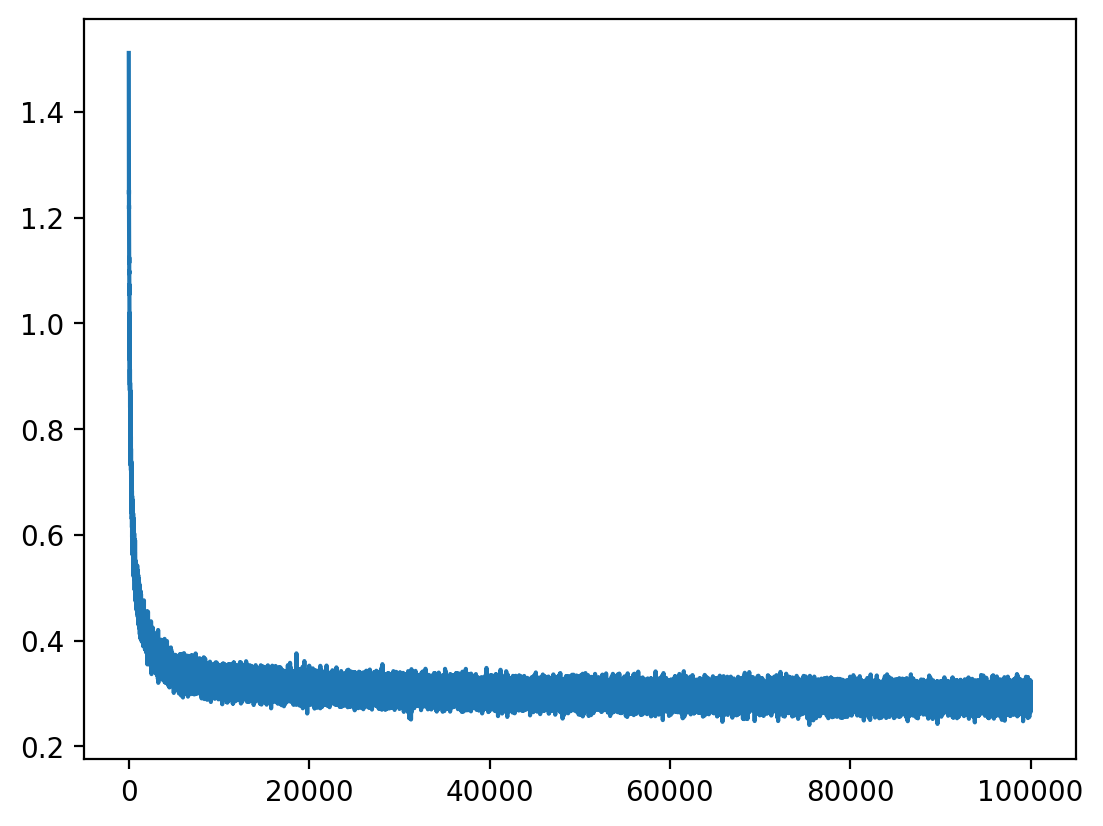

In [28]:
plt.plot(losses)

In [29]:
@torch.no_grad()
def calculate_loss(X, Y):
    emb = C[X]
    emb_flattened = emb.view(-1, (block_size*embed_size))
    h_preactivation = emb_flattened @ W1 
    h_preactivation = bnGain * (h_preactivation - bn_mean_running) / bn_std_running + bnBias
    h = torch.tanh(h_preactivation)
    logits = h @ W2 + b2
    return F.cross_entropy(logits, Y)

And against the validation set?

In [30]:
valid_loss = calculate_loss(Xvalid, Yvalid)
print(valid_loss.item())

1.9492636919021606


If the embeddings are 2D, we can visualise them.

It is interesting to see how the model has clustered them, it clearly isn't random.

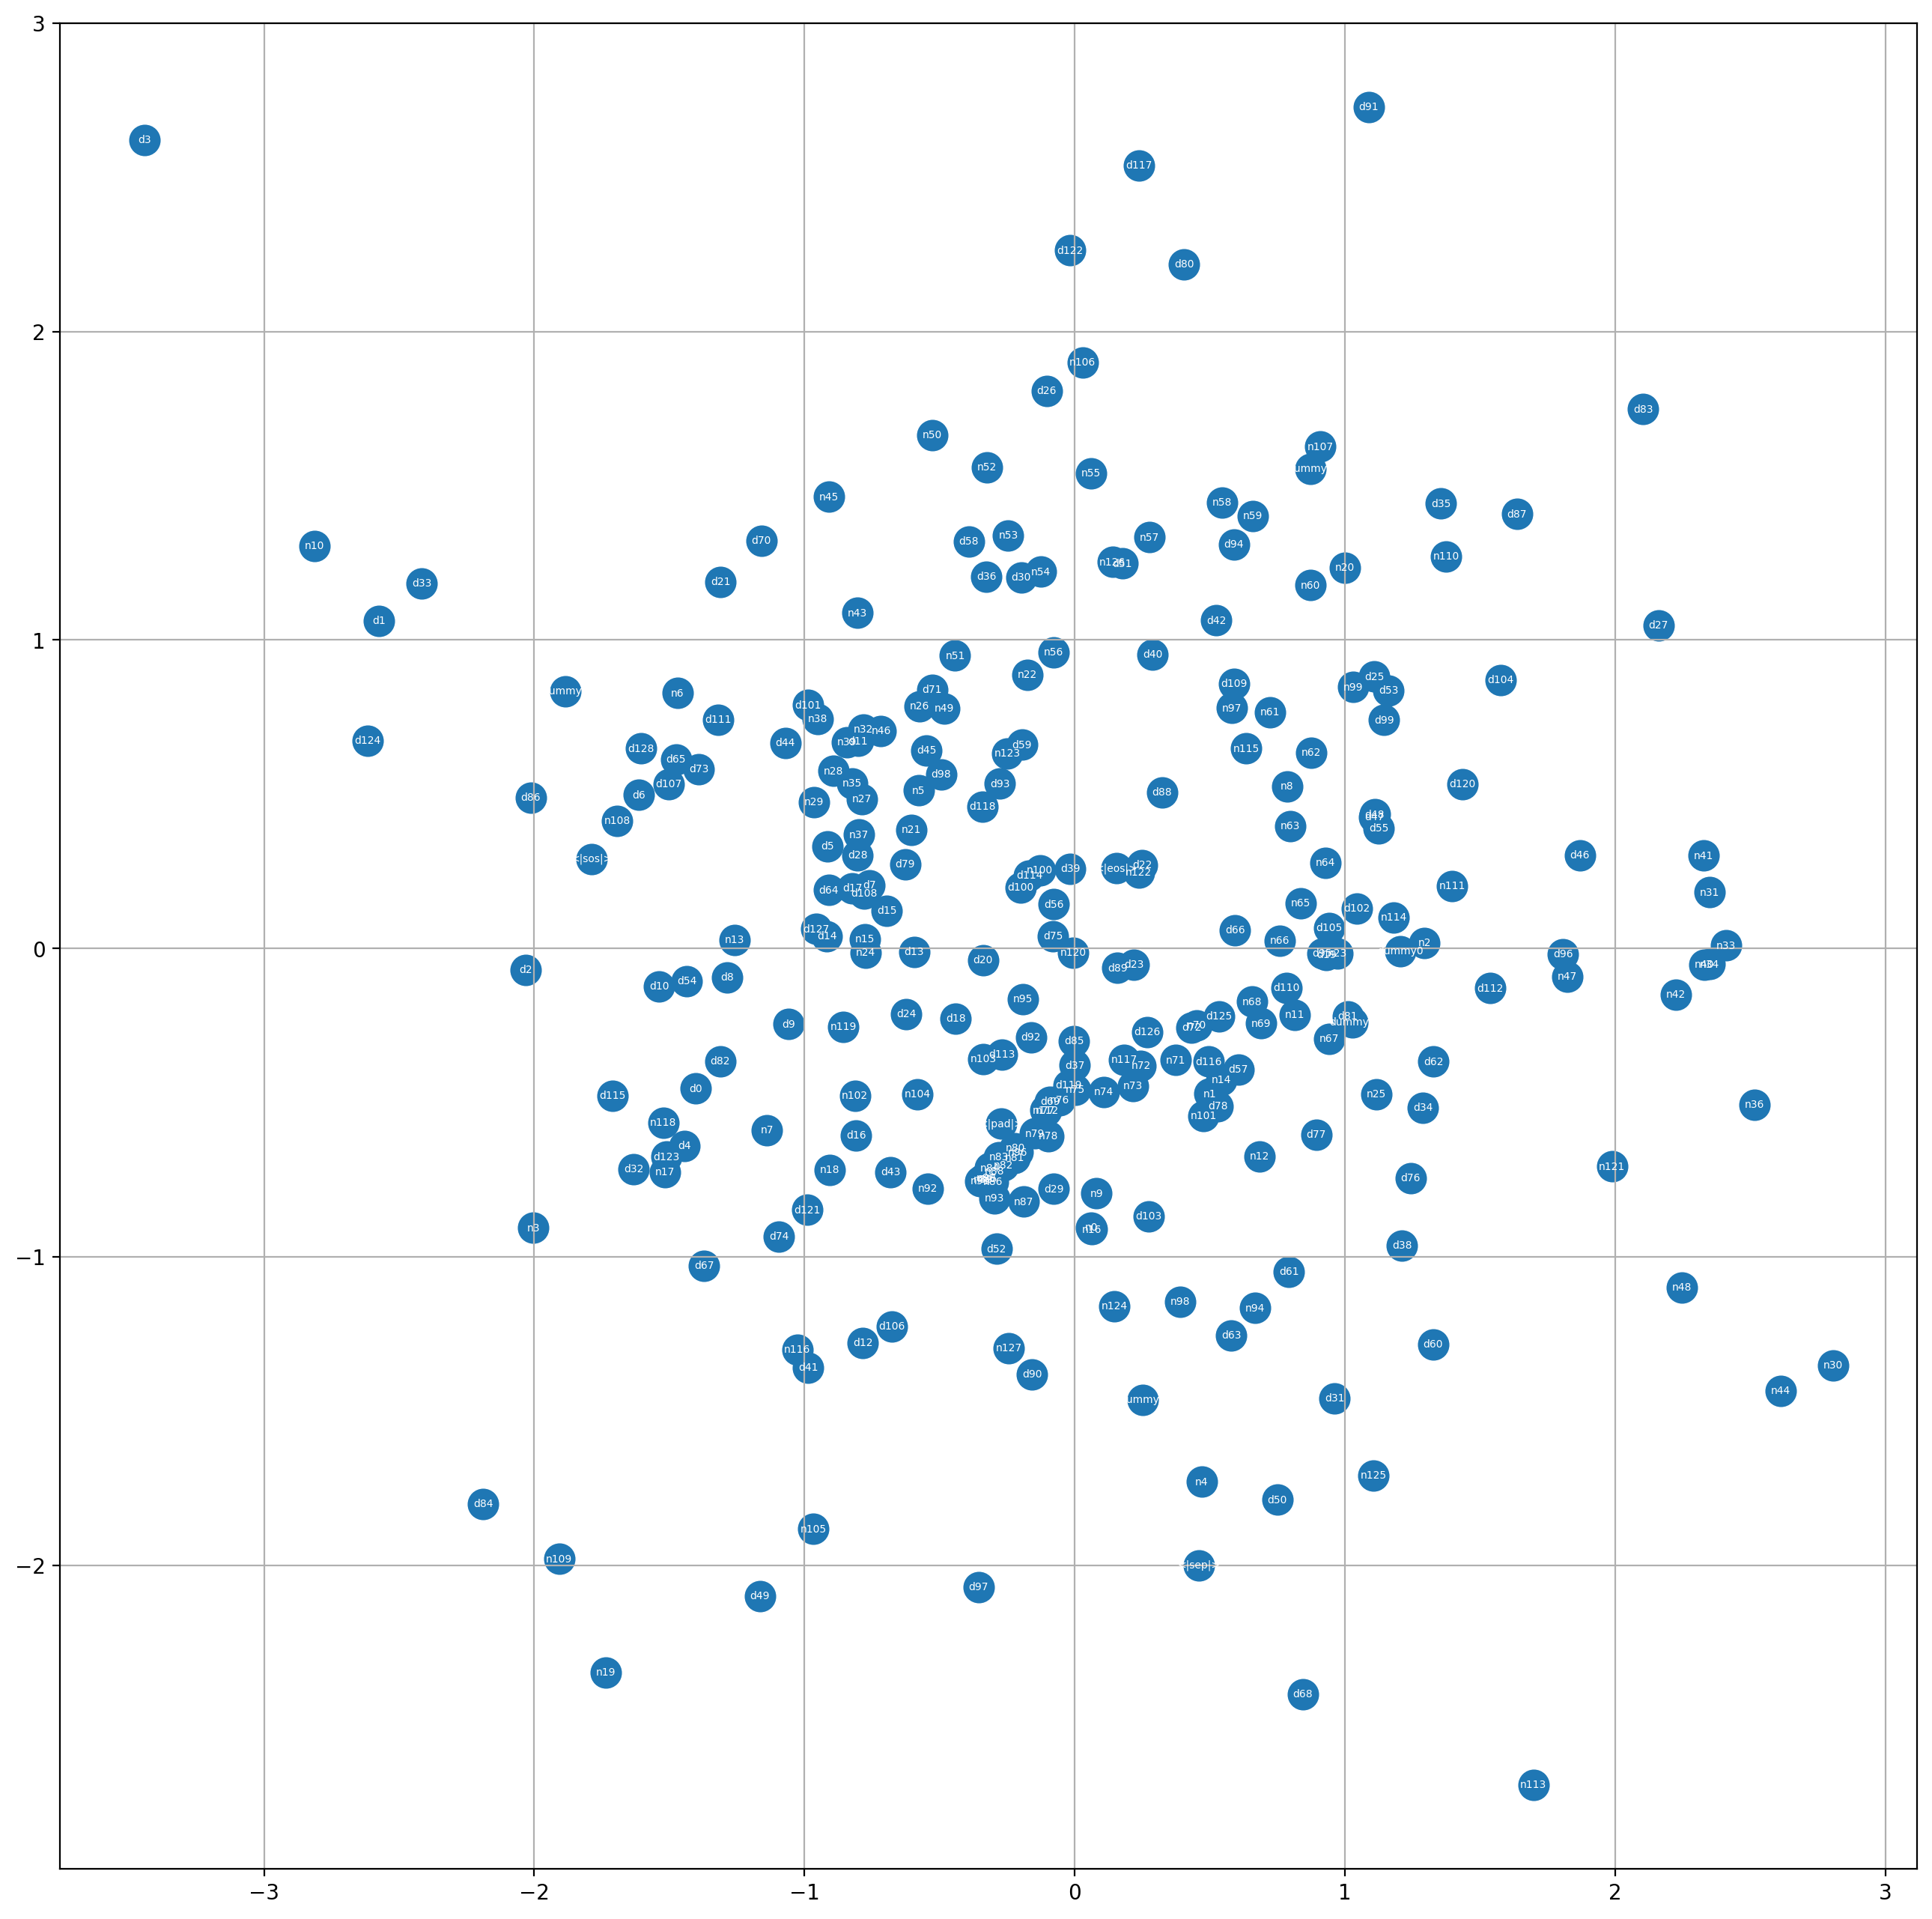

In [31]:
cpu_embeddings = C.detach().cpu()
plt.figure(figsize=(16, 16))
plt.scatter(cpu_embeddings[:, 0].data, cpu_embeddings[:, 1].data, s=200)
for i in range(vocab.size):
    plt.text(cpu_embeddings[i, 0], cpu_embeddings[i, 1], vocab.itos[i], ha='center', va='center', color='white', fontsize=5)
plt.grid('minor')

### Generation!

Finally, we can sample from the model, and see if it sounds any better than the random mess we got from the bigram model (I'm not too hopeful!).

In [32]:
# Sampling from the model
number_of_performances = 1
g = torch.Generator(device=device).manual_seed(2147483648 + 10)

for _ in range(number_of_performances):
    out = []
    context = [vocab.pad_idx, vocab.pad_idx, vocab.sos_idx]
    while True:
        emb = C[torch.tensor([context], device=device)]
        emb_flattened = emb.view(-1, (block_size*embed_size))
        h_preactivation = emb_flattened @ W1 
        h_preactivation = bnGain * (h_preactivation - bn_mean_running) / bn_std_running + bnBias
        h = torch.tanh(h_preactivation)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == vocab.eos_idx:
            break
        
print(vocab.to_tokens(out))

n55 d6 n52 d2 n43 d2 n33 d2 <|sep|> d2 n48 d2 <|sep|> d4 n54 d4 <|sep|> d3 n84 d4 <|sep|> d4 n79 d3 n71 d2 <|sep|> d2 n71 d6 n66 d8 <|sep|> d4 n66 d12 n39 d2 <|sep|> d2 n69 d2 <|sep|> d2 n65 d1 n58 d1 <|sep|> d1 n71 d1 n50 d1 <|sep|> d1 n60 d1 n35 d6 <|sep|> d6 n79 d6 n64 d1 <|sep|> d2 n28 d1 <|sep|> d2 n60 d2 <|sep|> d2 n76 d2 n67 d2 <|sep|> d1 n57 d2 <|sep|> d2 n77 d2 n48 d2 <|sep|> d2 n87 d2 n77 d2 n73 d2 n69 d2 n44 d2 <|sep|> d2 n52 d2 <|sep|> d2 n52 d2 <|sep|> d2 n41 d2 <|sep|> d2 n70 d2 <|sep|> d2 n75 d4 n66 d2 n60 d6 n43 d5 <|sep|> n25 d12 n104 d6 n72 d6 n56 d6 n72 d6 n64 d2 <|sep|> d2 n82 d2 <|sep|> d2 n46 d1 <|sep|> d2 n50 d2 <|sep|> d2 n85 d2 <|sep|> d2 n63 d2 n52 d2 <|sep|> d2 n72 d1 n63 d1 <|sep|> d1 n72 d1 n62 d1 <|sep|> d2 n50 d2 <|sep|> d2 n75 d6 n31 d5 n31 d2 n59 d2 <|sep|> d1 n46 d8 <|sep|> d2 n77 d4 n77 d4 <|sep|> d4 n86 d4 n72 d4 <|sep|> d1 n79 d1 n66 d1 n57 d1 <|sep|> d4 n69 d4 n62 d2 <|sep|> d2 n50 d2 <|sep|> d4 n72 d2 n68 d2 n65 d2 n57 d2 <|sep|> d2 n64 d4 n48 d2 

> Once again, the longer the slice of the performance, the more likely we will hit a note-note or duration-duration pair which will break the stream generation...

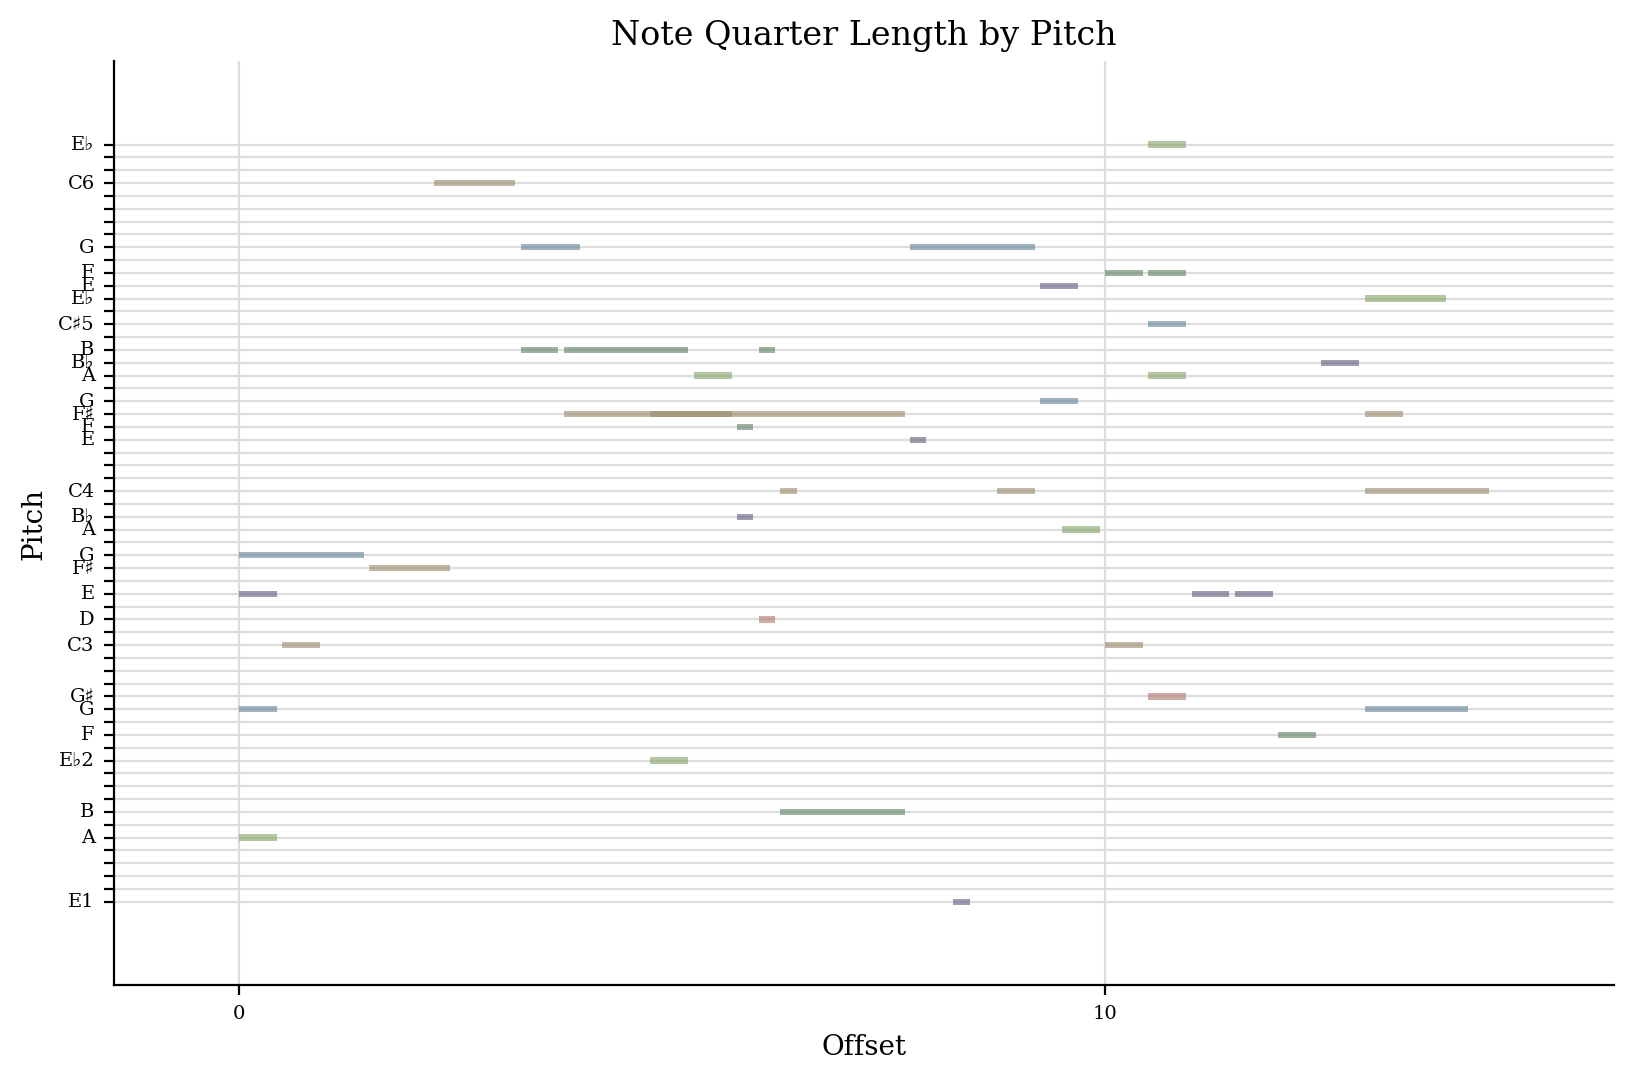

In [35]:
generated_stream = idx_to_stream_enc(np.array(out)[0:128], vocab)
generated_stream.plot()

In [36]:
generated_stream.show('midi')

Maaaaybe a little better but still junk ^_^

We are of course only using a very simple one-layer fully connected MLP and are crushing all the token information into two dimensional embeddings. We can't expect it to do anything very clever.

### Time

One major ommission from our current data is any sort of time / position encoding.

Time is obviously quite important when describing music, and will be particularly useful once we move on to attention mechanisms (i.e. Transformers).

We can augment the data with absolute positional information which can be used to infer bar and beat (providing you know the timestep resolution). We can create bar and beat embeddings that when trained intuitively capture some positional 'meaning' and can be combined with the token embeddings.

### Torchify

We can reproduce the model we have built so far with PyTorch quite easily, and that will allow us to iterate faster and explore more complex ideas.

In [76]:
n_hidden = 300
embed_size = 2
fan_in = embed_size*block_size

model = torch.nn.Sequential(
    torch.nn.Embedding(vocab.size, embed_size),
    torch.nn.Flatten(),
    torch.nn.Linear(fan_in, n_hidden, bias=False),
    torch.nn.BatchNorm1d(n_hidden),
    torch.nn.Tanh(),
    torch.nn.Linear(n_hidden, vocab.size)
)

print(sum(p.numel() for p in model.parameters()))

82998


> Remember that because we have batch norm, it is important to toggle the model into training / inference modes. In training mode we are keeping the running mean / variance. At inference time we will only have a single example which cannot have a variance.

In [77]:
iterations = 100000
learning_rate = 0.03
minibatch_size = 1024

model.to(device)
model.train()

losses = []    
for _ in range(iterations):

    # Configure minibatch
    ix = torch.randint(0, Xtrain.shape[0], (minibatch_size,))
    Yb = Ytrain[ix]
    Xb = Xtrain[ix]

    # Forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    # Backward pass
    model.zero_grad(set_to_none=True)
    loss.backward()

    # Update weights
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    losses.append(loss.log10().item())

print(loss.item())

1.9692044258117676


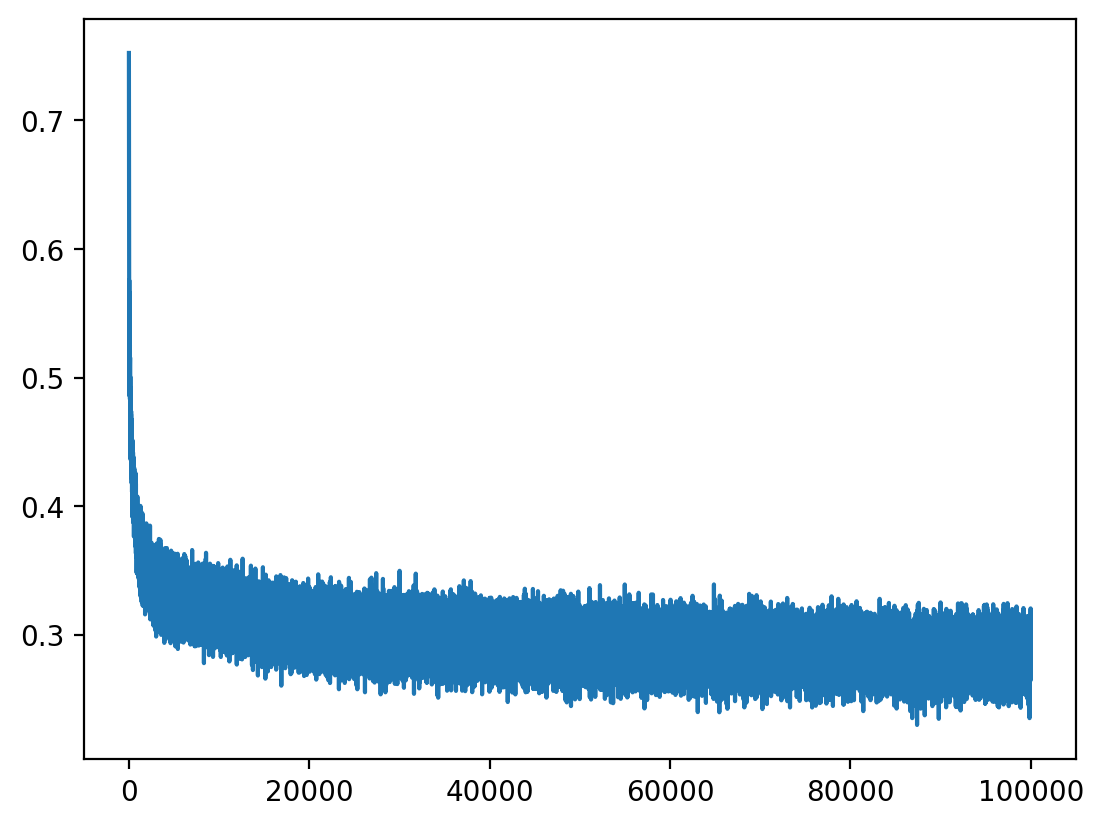

In [78]:
plt.plot(losses)